情感分析

情感分析是文本处理领域经典的问题。整个系统一般会包括几个模块：
- 数据的抓取： 通过爬虫的技术去网络抓取相关文本数据
- 数据的清洗/预处理：在本文中一般需要去掉无用的信息，比如各种标签（HTML标签），标点符号，停用词等等
- 把文本信息转换成向量： 这也成为特征工程，文本本身是不能作为模型的输入，只有数字（比如向量）才能成为模型的输入。所以进入模型之前，任何的信号都需要转换成模型可识别的数字信号（数字，向量，矩阵，张量...)
- 选择合适的模型以及合适的评估方法。 对于情感分析来说，这是二分类问题（或者三分类：正面，负面，中性），所以需要采用分类算法比如逻辑回归，朴素贝叶斯，神经网络，SVM等等。另外，我们需要选择合适的评估方法，比如对于一个应用，我们是关注准确率呢，还是关注召回率呢？ 

在本次项目中，我们已经给定了训练数据和测试数据，它们分别是 ``train.positive.txt``, ``train.negative.txt``， ``test_combined.txt``. 请注意训练数据和测试数据的格式不一样，详情请见文件内容。 整个项目你需要完成以下步骤：

数据的读取以及清洗： 从给定的.txt中读取内容，并做一些数据清洗，这里需要做几个工作： 
- （1） 文本的读取，需要把字符串内容读进来。 
- （2）去掉无用的字符比如标点符号，多余的空格，换行符等 
- （3） 把文本转换成``TF-IDF``向量： 这部分直接可以利用sklearn提供的``TfidfVectorizer``类来做。
- （4） 利用朴素贝叶斯等模型来做分类，并通过交叉验证选择最合适的超参数

项目中需要用到的数据：
- ``train.positive.txt``, ``train.negative.txt``， ``test_combined.txt``： 训练和测试数据
- ``stopwords.txt``： 停用词库


你需要完成的部分为标记为`TODO`的部分。

In [1]:
# 模块包加载
import pandas as pd
import numpy as np
import csv
import jieba
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, precision_score, recall_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
import seaborn as sns
import re


In [2]:
# 内容提取
def draw(data):
    
    contents_list = []
    classes_list = ""
    for i in data[0]:
        if  "id" in i:
            classes_list += i
        elif "/review" in i:
            classes_list += i
            contents_list.append(re.search('<review.*>(.*)</review>', classes_list).group(1).replace('\r', ""))
            classes_list = ""
        else:
            classes_list += i
    return contents_list

def test_draw(data):
    contents_list = []
    label = []
    classes_list = ""
    for i in data[0]:
        if  "id" in i:
            classes_list += i
        elif "/review" in i:
            classes_list += i
            contents_list.append(re.search('<review.*>(.*)</review>', classes_list).group(1).replace('\r', ""))
            label.append(int(re.search('label="([0, 1])"', classes_list).group(1)))
            classes_list = ""
        else:
            classes_list += i
    return contents_list, label

In [3]:
# 读取文本内容
def process_file():
    """
    读取训练数据和测试数据，并对它们做一些预处理
    """    
    train_pos_file = "./data/train.positive.txt"
    train_neg_file = "./data/train.negative.txt"
    test_comb_file = "./data/test.combined.txt"
    
    # TODO: 读取文件部分，把具体的内容写入到变量里面，判断下训练集中的positive和negtive样本是否均衡？
    # 数据读取
    pos_data = pd.read_csv(train_pos_file, header = None, sep = '\t', lineterminator = '\n')
    neg_data = pd.read_csv(train_neg_file, header = None, sep = '\t', lineterminator = '\n')
    comb_data = pd.read_csv(test_comb_file, header = None, sep = '\t', lineterminator = '\n')
    # 增加标签
    pos_data = pd.DataFrame(draw(pos_data))
    neg_data = pd.DataFrame(draw(neg_data))
    comb_datas, test_labels = test_draw(comb_data)
    comb_dtf_test = pd.DataFrame({"评论": comb_datas, "label": test_labels})

    pos_data['label'] = 1
    neg_data['label'] = 0
    # 训练集, 测试集定义
    train_comments = pos_data.append(neg_data)
    train_comments.rename({0: "评论"}, axis = 1, inplace = True)
    
    train_comment = train_comments["评论"]
    train_labels = train_comments["label"]

    test_comments = comb_dtf_test["评论"]
    test_label = comb_dtf_test['label']

    train_X, train_y, test_X, test_y = train_comment, train_labels, test_comments, test_label
    return train_X, train_y, test_X, test_y, train_comments, comb_dtf_test

# 数据提取
train_X, train_y, test_X, test_y, train_comments, comb_dtf_test = process_file()

In [4]:
print(train_comments.info(), comb_dtf_test.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8063 entries, 0 to 3064
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   评论      8063 non-null   object
 1   label   8063 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 189.0+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   评论      2500 non-null   object
 1   label   2500 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 39.2+ KB
None None


In [5]:
# 训练数据和测试数据大小
print (len(train_X), len(test_X))


8063 2500


TODO: 情感跟评论长度是否有相关性？

<AxesSubplot:ylabel='Count'>

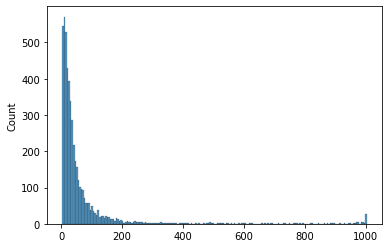

In [6]:
new_1 = train_comments.loc[train_comments['label'] == 1]
length1 = [len(i) for i in new_1['评论']]
sns.histplot(length1)

<AxesSubplot:ylabel='Count'>

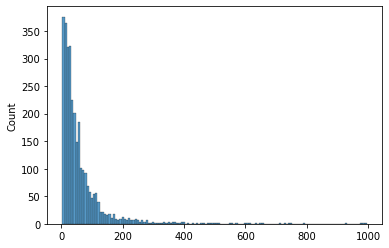

In [7]:
new_2 = train_comments.loc[train_comments['label'] == 0]
length2 = [len(i) for i in new_2['评论']]
sns.histplot(length2)

从图中可以看出, 在0 为差评. 1 为好评的情况下, 不论评论长度如何, 在每个感情下都存在相应的评论长度. 所以没有相关性

([<matplotlib.patches.Wedge at 0x24729872fa0>,
 [Text(0.40451460395460437, 1.0229212751661048, '0'),
  Text(-0.4045146997274046, -1.0229212372927097, '1')],
 [Text(0.22064432942978418, 0.5579570591815116, '38%'),
  Text(-0.2206443816694934, -0.557957038523296, '62%')])

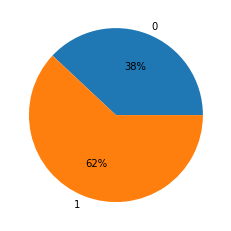

In [8]:
data_pie = train_comments.groupby("label").count()

plt.pie(data_pie["评论"], labels = data_pie.index, autopct = '%.f%%')

### 3. 文本预处理
> 在此部分需要做文本预处理方面的工作。 分为几大块：
- ``去掉特殊符号``  比如#$.... 这部分的代码已经给出，不需要自己写
- ``把数字转换成特殊单词`` 把数字转换成 " NUM "， 这部分需要写。 注意：NUM前面和后面加一个空格，这样可以保证之后分词时被分掉。
- ``分词并过滤掉停用词`` 停用词库已经提供，需要读取停用词库，并按照此停用词库做过滤。 停用词库使用给定的文件：``stopwords.txt`` 

从总体上来看, 好评占比 62%, 差评占比 38%, 

In [9]:
stopwords_data = "./data/stopwords.txt"
stopwords =df = pd.read_csv(stopwords_data, encoding='utf-8', header=None, sep='\t', quoting = csv.QUOTE_NONE)
stopwords

,0
0,———
1,》），
2,）÷（１－
3,”，
4,）、
...,...
762,啐
763,喔唷
764,嗬
765,嗯


In [10]:
def clean_symbols(text):
    """
    对特殊符号做一些处理，此部分已写好。如果不满意也可以自行改写。
    """
    text = re.sub('[!！]+', "", text)
    text = re.sub('[?？]+', "", text)
    text = re.sub('[~~ ]+', "", text)
    text = re.sub('[～～ ]+', "" , text)
    text = re.sub("\s+", " ", text)
    text = re.sub("[a-zA-Z#$%&\'()*+,-./:;：<=>@，。★、…【】《》“”‘’[\\]^_`{|}~]+", "", text)    # 1. 去掉特殊符号
    text = re.sub("\d+", " ", text)   #   2. 把数字转换成特殊字符或者单词
    text = jieba.lcut(text)   # 3. 分词并做停用词过滤
    res = []
    for i in text:
        if i not in stopwords[0]:
            res.append(i)
    result = " ".join(res)
    return result

In [11]:
# 打印一下看看
clean_train_comments = []
lis = list(train_X)
for item in lis:
    string = clean_symbols(item)
    clean_train_comments.append(string)

clean_test_comments = []
lis = list(test_X)
for item in lis:
    strings = clean_symbols(item)
    clean_test_comments.append(strings)

print(clean_train_comments[0], clean_test_comments[0])
print(clean_train_comments[1], clean_test_comments[1])

Building prefix dict from the default dictionary ...
Dumping model to file cache C:\Users\ADMINI~1\AppData\Local\Temp\jieba.cache
Loading model cost 2.554 seconds.
Prefix dict has been built successfully.


发短信 特别 方便 背后 的 屏幕 很大 用 起来 很 舒服 我 终于 找到 同道中人 啦 从 初中 开始 我 就 已经 喜欢 上 了 但 同学 们 都 用 鄙夷 的 眼光 看 我 他们 人为 的 样子 古怪 甚至 说 ＂ 丑 ＂ ． 我 当场 气晕 ． 但 现在 有 同道中人 了 我 好开心
手感 超好 而且 黑色 相比 白色 在 转得 时候 不 容易 眼花 找 童年 的 记忆 啦 看 完 已 是 深夜 两点 我 却 坐在 电脑前 情难 自禁 这是 最好 的 结局 惟有 如此 就让 那 前世 今生 的 纠结 就 停留 在 此刻 再 相逢 时愿 他 的 人生 不再 让 人 唏嘘 他们 的 身心 也 会 只 居 一处 可是 还是 痛心 为 这样 的 人 这样 的 爱


### 4. 把文本转换成向量
> 预处理好文本之后，我们就需要把它转换成向量形式，这里我们使用tf-idf的方法。 sklearn自带此功能，直接调用即可。输入就是若干个文本，输出就是每个文本的tf-idf向量。详细的使用说明可以在这里找到： 参考：https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html  这里需要特别注意的一点是：对于训练数据调用fit_transform, 也就是训练的过程。 但对于测试数据，不能再做训练，而是直接使用已经训练好的object做transform操作。

In [12]:
# TODO: 利用tf-idf从文本中提取特征,写到数组里面. 
#       参考：https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html

# 列表转换: 
X_train = clean_train_comments          
y_train = list(train_y)
X_test = clean_test_comments
y_test = list(test_y)

tfidf = TfidfVectorizer()    

tf_train_data = tfidf.fit_transform(clean_train_comments)
tf_train_data = tf_train_data.toarray()      

tf_test_data = tfidf.transform(clean_test_comments)
tf_test_data = tf_test_data.toarray()             #   VSM 矩阵

print (np.shape(tf_train_data), np.shape(tf_test_data), np.shape(y_train), np.shape(y_test))    # 矩阵有问题

(8063, 23715) (2500, 23715) (8063,) (2500,)


### 5. 通过交叉验证来训练模型(朴素贝叶斯模型不需要)
> 接下来需要建模了！ 这里我们分别使用逻辑回归，朴素贝叶斯来训练。针对于每一个方法我们使用交叉验证（gridsearchCV)， 并选出最好的参数组合，然后最后在测试数据上做验证。

In [13]:
# # 逻辑回归      
# #  到fit那部分一直报错, 找不到原因... 报错: TypeError            Traceback (most recent call last)

# parameters = {'talk': tf_train_data, 'label': y_train}
# lr = LogisticRegression()
# logistic_line = GridSearchCV(lr, parameters)
# logistic_line.fit(tf_train_data, y_train)
# pre = logistic_line.predict(tf_test_data)

# score1 = classification_report(y_test, pre, digits = 3)     # F1-score
# score2 = recall_score(y_test, pre)                          # recall
# score3 = precision_score(y_test, pre)                       # precision
# print(f"precision: {score3} \t recall: {score2} \t f1-score: {classification_report}")

ValueError: Parameter array for 'talk' should be one-dimensional, got: array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]]) with shape (8063, 23715)

In [ ]:
# TODO： 利用朴素贝叶斯来训练模型

naive = MultinomialNB()
naive.fit(tf_train_data, y_train)
score = naive.score(tf_test_data, y_test)
print(f'score为: {score}')

score为: 0.7216


### 6. 思考题 
1. 对于情感分析来说，有一个问题也很重要，比如一个句子里出现了 “我不太兴奋”， “不是很满意”。 在这种情况，因为句子中出现了一些积极的词汇很可能被算法识别成正面的，但由于前面有一个“不”这种关键词，所以否定+肯定=否定，算法中这种情况也需要考虑。另外，否定+否定=肯定， 这种情况也一样。 

>``Q``: 对于如上问题，有什么解决方案？ 大概列一下能想到的处理方案。 用简介的文字来描述即可。  

  加入判断条件, 如果出现 我不, 不是XXXXX, 等含有负面的词, 判断后面的内容是否存在正面的词, 例如: 我不兴奋, 我不忧愁, 这里记兴奋为1, 忧愁为0, 在前面出现"不" 的情况下, 我不太兴奋记为01 从而得到 0 , 表示负面的词, 我不忧愁记为00 或者 我快乐兴奋为 11, 记为1, 也就是判断两个代表情绪的数字是否相同, 如果相同则为正面的次, 如果不同(01, 10) 为负面的词, 不过，通过遍历可能计算量会变大。